<a href="https://colab.research.google.com/github/ksanjeevan/fauxgrad/blob/master/fauxgrad_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/ksanjeevan/fauxgrad.git

  Cloning https://github.com/ksanjeevan/fauxgrad.git to /tmp/pip-req-build-pjutahbu
  Running command git clone -q https://github.com/ksanjeevan/fauxgrad.git /tmp/pip-req-build-pjutahbu
  Resolved https://github.com/ksanjeevan/fauxgrad.git to commit 79a7535ea244d5f5d49476fbea6bdef006d370c0
  Created wheel for fauxgrad: filename=fauxgrad-0.1-py3-none-any.whl size=3579 sha256=0928c727e3c167e8d4a43ccad8a706db785c667e8641a40ee1de91f6ec7f1278
  Stored in directory: /tmp/pip-ephem-wheel-cache-vpyw8afx/wheels/0c/84/72/e6e6b746cab909ceec90dbff175675a52259a515cfba9b8518
Successfully built fauxgrad


In [2]:
import matplotlib.pyplot as plt
import numpy as np

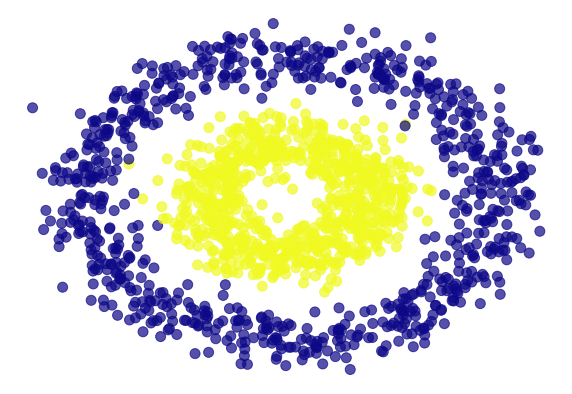

In [3]:
# collect 2d toy data of a donut in a donut
from fauxgrad.utils import generate_circles, visualize_plot
X, Y = generate_circles(num_samples=1600)


# Let's display the data
plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1], c=np.squeeze(Y), cmap='plasma', s=100, alpha=0.7)
ax = plt.gca()
ax.set_facecolor((0.95, 0.95, 0.95))
plt.axis('off'); plt.show()

In [4]:
# Value is the engine of the automatic differentiation, while
# Linear simply implements `List[Value]` based matrix multiplication 
from fauxgrad import Value, Linear

class MyNet:
    
    def __init__(self, hidden_size=12):
        self.l1 = Linear(2, hidden_size, 'relu')
        self.l2 = Linear(hidden_size, 1, 'sigmoid')
        
    def __call__(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return x

    def parameters(self):
        return self.l1.parameters() + self.l2.parameters()


def nll_loss(pred, target):
    # this is a bit ugly, as it's at the expense of not implementing __sub__, etc.
    ret = [-p.log() if t == 1 else -(-p+1).log() for p, t in zip(pred, target)]
    return sum(ret)

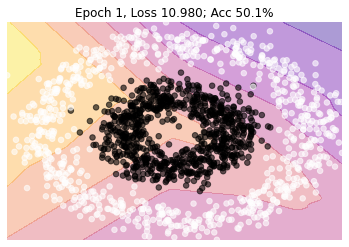

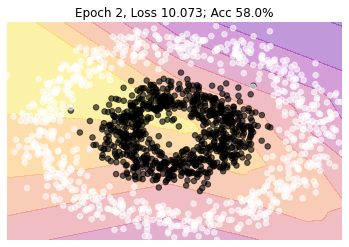

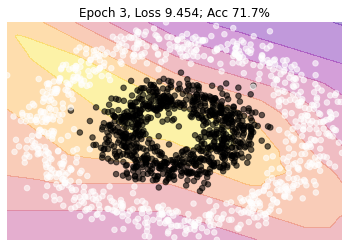

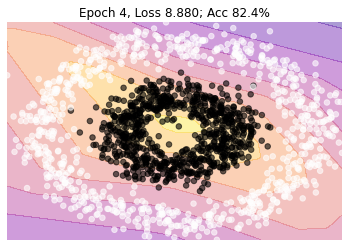

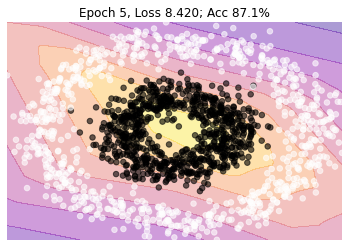

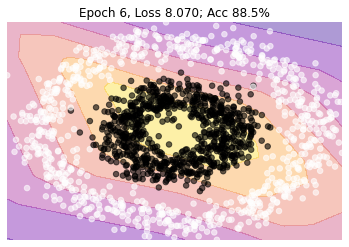

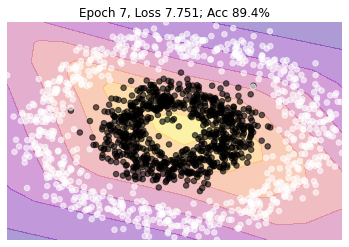

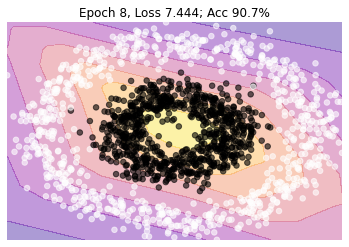

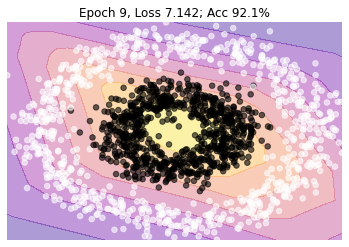

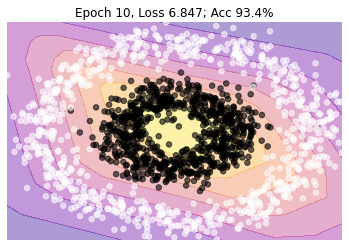

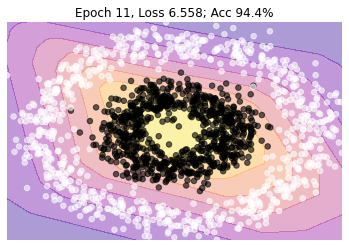

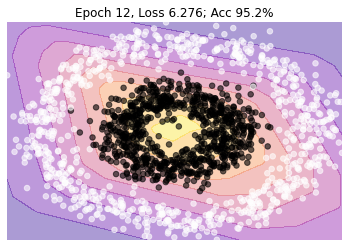

In [6]:
m = MyNet()

data = X.reshape(100, 16, 2) 
labels = Y.reshape(100, 16)

iters, batch_size = data.shape[:2]

from fauxgrad.optim import SGD
epochs = 12
lr = 0.001
opt = SGD(m.parameters(), lr=lr)

for epoch in range(1, epochs+1):
    losses = []; accs = []
    
    for i in range(iters):
        x = [[Value(d[0]), Value(d[1])] for d in data[i]]

        opt.zero_grad()
        yhat = [m(datum)[0] for datum in x]

        loss = nll_loss(yhat, labels[i])
        loss.backward()
        
        losses.append(loss.val)
        accs.extend([int(y.val>0.5)==l for y, l in zip(yhat, labels[i])])

        opt.step()
    title = 'Epoch %d, Loss %.3f; Acc %.1f%%'%(epoch,
                                               sum(losses)/len(losses), 
                                               100*sum(accs)/len(accs))
    visualize_plot(X, Y, m, title=title)